In [5]:
# README

# Tensorflow implementation of the paper: "A Neural Algorithm of Artistic Style"
# You can know more about the paper here: "https://arxiv.org/abs/1508.06576

# Inputs:
# 1. Content Image, 
# 2. Style Image

# Output:
# Generated Image(G)

# Unlike other optimization problems, we don't optimize the cost function to get weights. Here, we try to find the pixels of the 
# final(content+style) generated image(G) by reducing the error of the cost function.

# There are two cost functions:
# 1. J_content
# 2. J_style

# Total cost function: 
# J_total = alpha*J_content + beta*J_style

In [6]:
# Import modules

import scipy
import numpy as np
import tensorflow as tf
from scipy import io as sio
from scipy import ndimage, misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import warnings
warnings.filterwarnings('ignore') # Ignores warnings.

In [7]:
# Reading VGG19 weights and converting each layer into tensors and storing them in a dictionary.
# Paper: Very deep convolutional networks for large-scale image recognition: https://arxiv.org/pdf/1409.1556.pdf  

path_vgg19_weights = '../pretrained_models/imagenet-vgg-verydeep-19.mat'
vgg_model = sio.loadmat(path_vgg19_weights)
vgg_layers = vgg_model['layers']

def conv2d(previous_layer, layer):
    W = vgg_layers[0][layer][0][0][2][0][0]
    b = vgg_layers[0][layer][0][0][2][0][1]
    layer_name = vgg_layers[0][layer][0][0][0][0]
    convolution = tf.nn.conv2d(previous_layer, filter = tf.constant(W), strides = [1,1,1,1], padding = 'SAME')
    bias = tf.constant(np.reshape(b, b.size))
    return convolution + bias

image_height = 300
image_width = 400
channels = 3 # RGB

# Create tensors for each layer.
model = {}
model['input_image'] = tf.Variable(np.zeros((1, image_height, image_width, channels)), dtype = 'float32')

model['conv1_1'] = tf.nn.relu(conv2d(model['input_image'], 0))
model['conv1_2'] = tf.nn.relu(conv2d(model['conv1_1'], 2))
model['avgpool1'] = tf.nn.avg_pool(model['conv1_2'], ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

model['conv2_1'] = tf.nn.relu(conv2d(model['avgpool1'], 5))
model['conv2_2'] = tf.nn.relu(conv2d(model['conv2_1'], 7))
model['avgpool2'] = tf.nn.avg_pool(model['conv2_2'], ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

model['conv3_1'] = tf.nn.relu(conv2d(model['avgpool2'], 10))
model['conv3_2'] = tf.nn.relu(conv2d(model['conv3_1'], 12))
model['conv3_3'] = tf.nn.relu(conv2d(model['conv3_2'], 14))
model['conv3_4'] = tf.nn.relu(conv2d(model['conv3_3'], 16))
model['avgpool3'] = tf.nn.avg_pool(model['conv3_4'], ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

model['conv4_1'] = tf.nn.relu(conv2d(model['avgpool3'], 19))
model['conv4_2'] = tf.nn.relu(conv2d(model['conv4_1'], 21))
model['conv4_3'] = tf.nn.relu(conv2d(model['conv4_2'], 23))
model['conv4_4'] = tf.nn.relu(conv2d(model['conv4_3'], 25))
model['avgpool4'] = tf.nn.avg_pool(model['conv4_4'], ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

model['conv5_1'] = tf.nn.relu(conv2d(model['avgpool4'], 28))
model['conv5_2'] = tf.nn.relu(conv2d(model['conv5_1'], 30))
model['conv5_3'] = tf.nn.relu(conv2d(model['conv5_2'], 32))
model['conv5_4'] = tf.nn.relu(conv2d(model['conv5_3'], 34))
model['avgpool5'] = tf.nn.avg_pool(model['conv5_4'], ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')


Content Image:


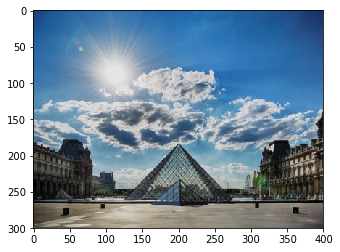

Style Image:


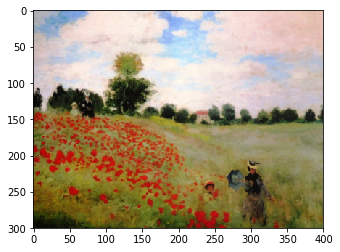

In [8]:
# Read content and style images
content_image = scipy.misc.imread("images/louvre.jpg")
content_image = np.array([misc.imresize(content_image, (300, 400))])
imshow(content_image[0])
print "Content Image:"
plt.show()

style_image = scipy.misc.imread("images/monet_800600.jpg")
style_image = np.array([misc.imresize(style_image, (300, 400))])
imshow(style_image[0])
print "Style Image:"
plt.show()

Noise Image:


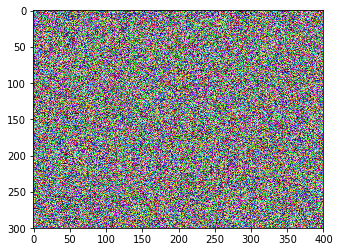

In [9]:
# Generate a noisy random image - Generated image
noise_image = np.random.uniform(-20, 20, size=(1, image_height, image_width, channels)) 
generated_image = noise_image * 0.6 + content_image * (1 - 0.6)
imshow(generated_image[0])
print "Noise Image:"
plt.show()

In [28]:
# J_content: Cost between content image and generated image.

def compute_J_content(layer_name):
    # Activations of content image in layer 'conv4_2' - constant
    content_activation = sess.run(model[layer_name])
    shape = content_activation.shape
    
    # Activations of generated image in layer 'conv4_2' - variable
    generated_activation = model[layer_name]

    # Compute content cost: J_content
    height = shape[1]
    width = shape[2]
    channels = shape[3]

    J_content = tf.reduce_sum(tf.square(tf.subtract(content_activation, generated_activation)))
    J_content = J_content/2.0
    print 'Computed content cost.'
    return J_content
    
sess = tf.InteractiveSession()
sess.run(model["input_image"].assign(content_image))
J_content = compute_J_content('conv4_2')
print J_content

Computed content cost.
Tensor("div_4:0", shape=(), dtype=float32)


In [30]:
def compute_J_style(model, layers):
    
    J_style = 0
    
    for layer in layers:
        # Activations of style image in some layer
        style_activation = sess.run(model[layer])
        shape = style_activation.shape
        
        height = shape[1]
        width = shape[2]
        channels = shape[3]

        # Reshape style_activations
        print style_activation.shape
        style_activation = tf.reshape(style_activation, [height*width, channels])
        print style_activation.shape
        
        # Compute Gram matrix for style_activation
        style_gram_matrix = tf.matmul(tf.transpose(style_activation), style_activation)
        print style_gram_matrix.shape
        
        # Activations of generated image
        generated_activation = model[layer]
        
        # Reshape generated_activations
        generated_activation = tf.reshape(generated_activation, [height*width, channels])
        
        # Compute Gram matrix for generated_activation
        generated_gram_matrix = tf.matmul(tf.transpose(style_activation), style_activation)
        print generated_gram_matrix.shape
        
        M = height*width
        N = channels
        
        # Compute J_style for this layer and add.
        J_style_for_this_layer = (1/(4.0*(N**2)*(M**2))) * tf.reduce_sum(tf.square(tf.subtract(style_activation, generated_activation))) 
        J_style += (1.0/len(layers)) * J_style_for_this_layer
        
        return J_style
        
sess.run(model["input_image"].assign(content_image))
layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
J_style = compute_J_style(model, layers)
print J_style

(1, 300, 400, 64)
(120000, 64)
(64, 64)
(64, 64)
Tensor("add_33:0", shape=(), dtype=float32)


In [35]:
def compute_J_total(alpha, J_content, beta, J_style):
    J_total = alpha*J_content + beta*J_style
    return J_total

# alpha/beta = 0.001 or 0.0001
alpha = 10
beta = 40
J_total = compute_J_total(alpha, J_content, beta, J_style)
print J_content.shape
print J_style.shape

()
()
